In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
torch.set_default_dtype(torch.float64)
import torch.nn as nn
import copy
import random

In [2]:
import config as cfg
from model import DeepNN
from utils import relative_l2, set_seed
from train_reg import train_model_reg
from train_pde import train_model_pde

In [3]:
set_seed(0)
model_E = DeepNN().cuda()
model_T = DeepNN().cuda()
[model_E, model_T] = train_model_reg(model_E, model_T, Nfit=300, lr_E=1e-2, lr_T=1e-2)

E: lbfgs : 0 - ref_rl2 7.9264e-02 
T: lbfgs : 0 - ref_rl2 2.8363e-01 
E: lbfgs : 50 - ref_rl2 3.3780e-04 
T: lbfgs : 50 - ref_rl2 3.4262e-05 
E: lbfgs : 100 - ref_rl2 3.3554e-04 
T: lbfgs : 100 - ref_rl2 9.4766e-06 
E: lbfgs : 150 - ref_rl2 3.3534e-04 
T: lbfgs : 150 - ref_rl2 9.4369e-06 
E: lbfgs : 200 - ref_rl2 3.3515e-04 
T: lbfgs : 200 - ref_rl2 9.4057e-06 
E: lbfgs : 250 - ref_rl2 3.3497e-04 
T: lbfgs : 250 - ref_rl2 9.3786e-06 
E: lbfgs : 299 - ref_rl2 3.3480e-04 
T: lbfgs : 299 - ref_rl2 9.3573e-06 


In [4]:
set_seed(50)
model_E_cur = DeepNN().cuda()
model_E_cur.load_state_dict(copy.deepcopy(model_E.state_dict()))
model_T_cur = DeepNN().cuda()
model_T_cur.load_state_dict(copy.deepcopy(model_T.state_dict()))
[model_E_cur, model_T_cur] = train_model_pde(model_E_cur, model_T_cur, Nfit=200, lr_E=1e-1, lr_T=1e-1)

E: adam : 0 - ref_rl2 8.8863e-02 - pde 1.5867e+00 - lbc 1.4166e-02 - rbc 4.5656e-02 - tbc 1.4747e-01 - bbc 8.8305e-02
T: adam : 0 - ref_rl2 1.2459e-05 - pde 1.5933e-03 - lbc 1.7113e-06 - rbc 2.7206e-02 - tbc 2.1357e-04 - bbc 2.2243e-04
E: adam : 10 - ref_rl2 8.9908e-04 - pde 1.4694e-02 - lbc 1.3931e-04 - rbc 1.0591e-03 - tbc 2.2341e-03 - bbc 2.1407e-03
T: adam : 10 - ref_rl2 9.3116e-06 - pde 1.5911e-03 - lbc 1.9739e-06 - rbc 2.7185e-02 - tbc 1.6942e-04 - bbc 1.9419e-04
E: adam : 20 - ref_rl2 8.9655e-04 - pde 1.4648e-02 - lbc 1.3915e-04 - rbc 1.0577e-03 - tbc 2.2311e-03 - bbc 2.1374e-03
T: adam : 20 - ref_rl2 7.7912e-06 - pde 1.5899e-03 - lbc 1.9073e-06 - rbc 2.7256e-02 - tbc 1.4770e-04 - bbc 1.5293e-04
E: adam : 30 - ref_rl2 8.9259e-04 - pde 1.4576e-02 - lbc 1.3898e-04 - rbc 1.0634e-03 - tbc 2.2256e-03 - bbc 2.1326e-03
T: adam : 30 - ref_rl2 6.8283e-06 - pde 1.5893e-03 - lbc 1.9351e-06 - rbc 2.7098e-02 - tbc 1.2431e-04 - bbc 1.1703e-04
E: adam : 40 - ref_rl2 8.8510e-04 - pde 1.4440e-02

In [5]:
X = cfg.X.detach().cpu()
Y = cfg.Y.detach().cpu()
E_reg = model_E(cfg.inp_fine, cfg.Z_fine).detach().cpu().reshape(cfg.Nx, cfg.Ny)
E_pinn = model_E_cur(cfg.inp_fine, cfg.Z_fine).detach().cpu().reshape(cfg.Nx, cfg.Ny)
E_ref = cfg.E_ref.cpu()
T_reg = model_T(cfg.inp_fine, cfg.Z_fine).detach().cpu().reshape(cfg.Nx, cfg.Ny)
T_pinn = model_T_cur(cfg.inp_fine, cfg.Z_fine).detach().cpu().reshape(cfg.Nx, cfg.Ny)
T_ref = cfg.T_ref.cpu()

In [6]:
print('E: Regression Solution rl2: {:.4e}'.format(relative_l2(E_ref, E_reg)))
print('E: PINN Solution rl2: {:.4e}'.format(relative_l2(E_ref, E_pinn)))

print('T: Regression Solution rl2: {:.4e}'.format(relative_l2(T_ref, T_reg)))
print('T: PINN Solution rl2: {:.4e}'.format(relative_l2(T_ref, T_pinn)))

E: Regression Solution rl2: 3.3480e-04
E: PINN Solution rl2: 9.2222e-04
T: Regression Solution rl2: 9.3573e-06
T: PINN Solution rl2: 4.3018e-06


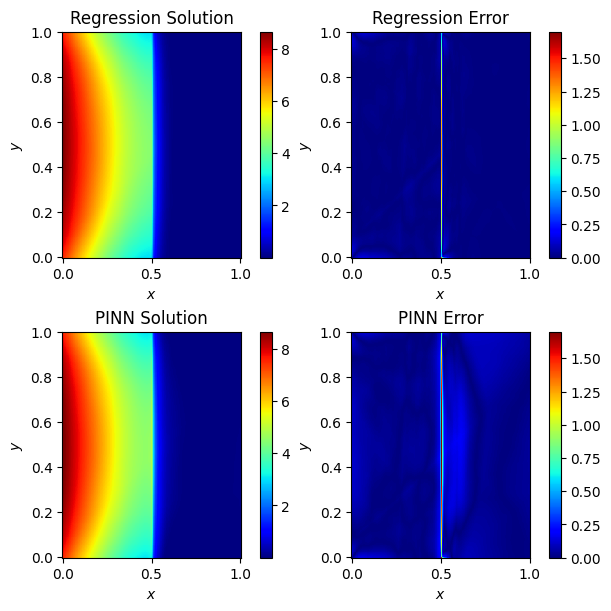

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), layout='constrained')

vmin = E_ref.min()
vmax = E_ref.max()

pcm = axs[0][0].pcolormesh(X, Y, E_reg, vmin=vmin, vmax=vmax, cmap='jet')
axs[0][0].set_title("Regression Solution")
axs[0][0].set_xlabel("$x$")
axs[0][0].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[0][0])

pcm = axs[0][1].pcolormesh(X, Y, (E_ref - E_reg).abs(), vmin=0, vmax=1.7, cmap='jet')
axs[0][1].set_title("Regression Error")
axs[0][1].set_xlabel("$x$")
axs[0][1].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[0][1])

pcm = axs[1][0].pcolormesh(X, Y, E_pinn, vmin=vmin, vmax=vmax, cmap='jet')
axs[1][0].set_title("PINN Solution")
axs[1][0].set_xlabel("$x$")
axs[1][0].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[1][0])

pcm = axs[1][1].pcolormesh(X, Y, (E_ref - E_pinn).abs(), vmin=0, vmax=1.7, cmap='jet')
axs[1][1].set_title("PINN Error")
axs[1][1].set_xlabel("$x$")
axs[1][1].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[1][1])

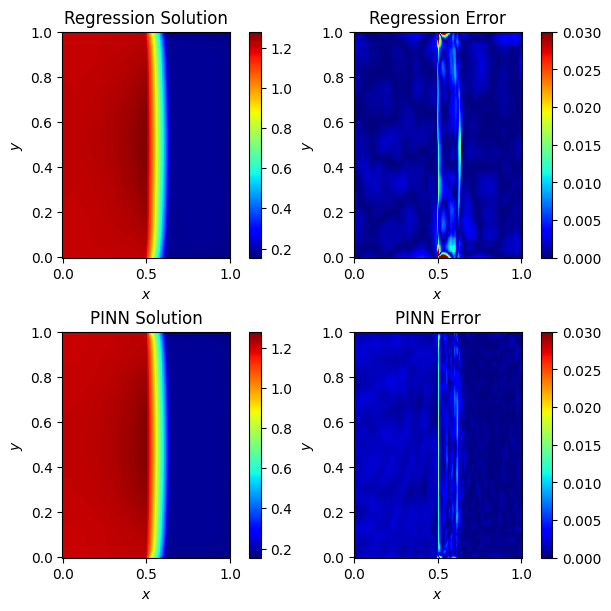

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), layout='constrained')

vmin = T_ref.min()
vmax = T_ref.max()

pcm = axs[0][0].pcolormesh(X, Y, T_reg, vmin=vmin, vmax=vmax, cmap='jet')
axs[0][0].set_title("Regression Solution")
axs[0][0].set_xlabel("$x$")
axs[0][0].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[0][0])

pcm = axs[0][1].pcolormesh(X, Y, (T_ref - T_reg).abs(), vmin=0, vmax=0.03, cmap='jet')
axs[0][1].set_title("Regression Error")
axs[0][1].set_xlabel("$x$")
axs[0][1].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[0][1])

pcm = axs[1][0].pcolormesh(X, Y, T_pinn, vmin=vmin, vmax=vmax, cmap='jet')
axs[1][0].set_title("PINN Solution")
axs[1][0].set_xlabel("$x$")
axs[1][0].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[1][0])

pcm = axs[1][1].pcolormesh(X, Y, (T_ref - T_pinn).abs(), vmin=0, vmax=0.03, cmap='jet')
axs[1][1].set_title("PINN Error")
axs[1][1].set_xlabel("$x$")
axs[1][1].set_ylabel("$y$")
fig.colorbar(pcm, ax=axs[1][1])